# Part 2: Advanced Configuration

In [2]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import plotting
import os

#

## Load the dataset

In [3]:
X_train_val = np.load('X_train_val.npy')
X_test = np.ascontiguousarray(np.load('X_test.npy'))
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy', allow_pickle=True)
classes = np.load('classes.npy', allow_pickle=True)

## Load the model
Load the model trained in 'part1_getting_started'. **Make sure you've run through that walkthrough first!**

In [4]:
from tensorflow.keras.models import load_model

model = load_model('model_1/KERAS_check_best_model.keras')
y_keras = model.predict(X_test)

2025-10-14 22:04:03.782241: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


5188/5188 [==============================] - 10s 2ms/step


## Make an hls4ml config & model

When the parameter `granularity` is set to `'name'` in the `config_from_keras_model` function, hls4ml automatically chooses the fixed-point precision for the ouput variables and accumulators for each layer. The accumulators are internal variables used for accumulating values during matrix multiplications. 

This precision choice is **conservative**. It avoids overflow and truncation based solely on input bitwidths, without considering the actual input values. Once again, this approach can be overly conservative, especially when post-training quantization is employed or if the initial input bitwidth settings are relatively loose. In such cases, it is advisable to manually edit the configuration to explicitly set specific widths, potentially iteratively after profiling the data.

In this notebook, we'll create a configuration with the finer granularity (`'name'`). When we print the config dictionary, you'll notice that an entry is created for each named Layer of the model and the types are set to `auto`. For example, for the first layer we have:
```
LayerName:
    ...
    fc1:
        Trace:       False
        Precision:
            weight:  auto
            bias:    auto
            result:  auto
            accum:   auto
        ReuseFactor: 1
    ...
```

In Part 1, all the parameters were set to the same default model precision. In this notebook instead, because of the `granularity='name'` and thus `'auto'` precision selection:
- `weight` and `bias` are set to the default model precision;
- `result` and `accum` are set to conservative bit-widths that avoid overflow and truncation.

Later on, you will see that you can use this configuration as a template to start modifying things.

In [5]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: Activation
Layer name: fc3, layer type: Dense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation
-----------------------------------
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
LayerName
  fc1_input
    Precision
      result:        ap_fixed<16,6>
  fc1
    Precision
      weight:        ap_fixed<16,6>
      bias:          ap_fixed<16,6>
      result:        ap_fixed<16,6>
    ReuseFactor:     1
  fc1_linear
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    table_size: 

/home/chanssen/miniconda3/envs/hls4ml-env/lib/python3.10/site-packages/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


## Profiling
As you can see, we can choose the precision of _everything_ in our Neural Network. This is a powerful way to tune the performance, but it's also complicated. The tools in `hls4ml.model.profiling` can help you choose the right precision for your model. (That said, training your model with quantization built in can get around this problem, and that is introduced in Part 4. So, don't go too far down the rabbit hole of tuning your data types without first trying out quantization aware training with QKeras.)

The first thing to try is to numerically profile your model. This method plots the distribution of the weights (and biases) as a box and whisker plot. The grey boxes show the values which can be represented with the data types used in the `hls_model`. Generally, you need the box to overlap completely with the whisker 'to the right' (large values) otherwise you'll get saturation & wrap-around issues. It can be okay for the box not to overlap completely 'to the left' (small values), but finding how small you can go is a matter of trial-and-error.

Providing data, in this case just using the first 1000 examples for speed, will show the same distributions captured at the output of each layer.

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
Creating HLS model
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]],

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>)

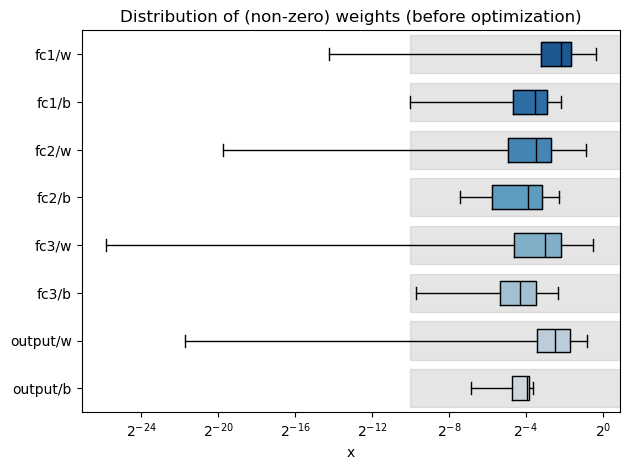

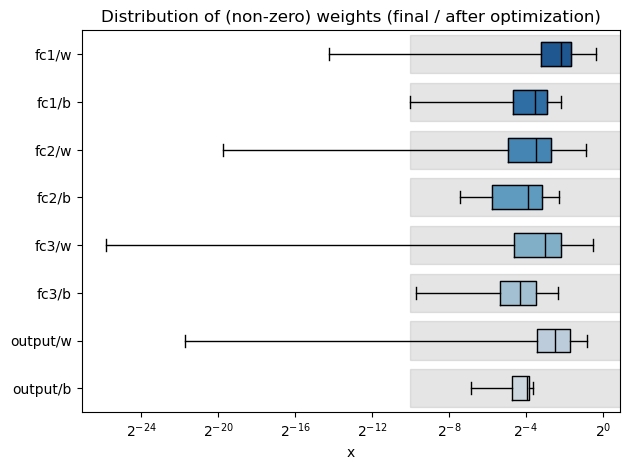

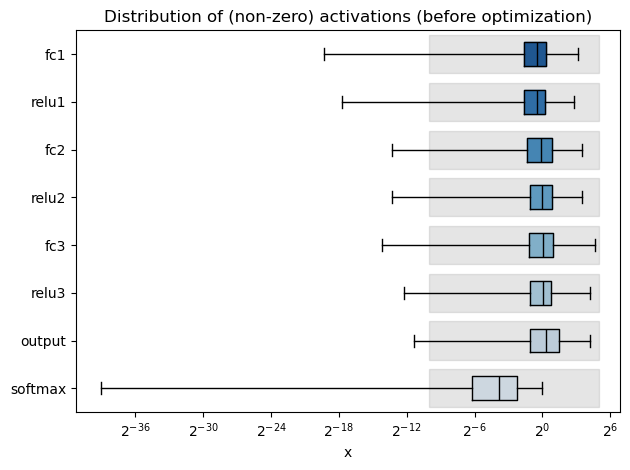

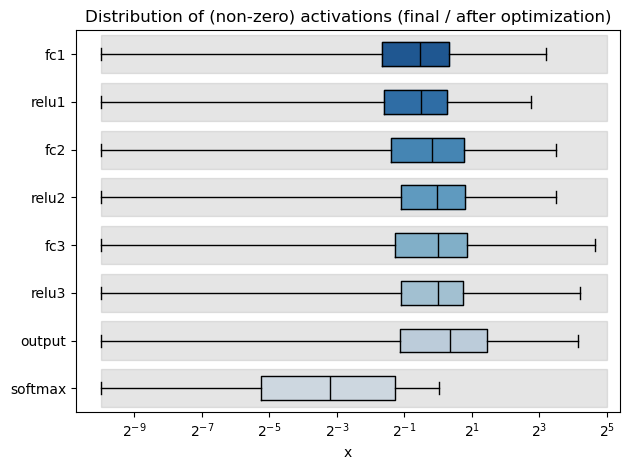

In [6]:
%matplotlib inline
from hls4ml.model.profiling import numerical, get_ymodel_keras

for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj_2', part='xc7vx690tffg1761-2'
)
numerical(model=model, hls_model=hls_model, X=X_test[:1000])

## Customize
Let's just try setting the precision of the first layer weights to something more narrow than 16 bits. Using fewer bits can save resources in the FPGA. After inspecting the profiling plot above, let's try 8 bits with 1 integer bit.

Then create a new `HLSModel`, and display the profiling with the new config. This time, just display the weight profile by not providing any data '`X`'. Then create the `HLSModel` and display the architecture. Notice the box around the weights of the first layer reflects the different precision.

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
Creating HLS model
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]],

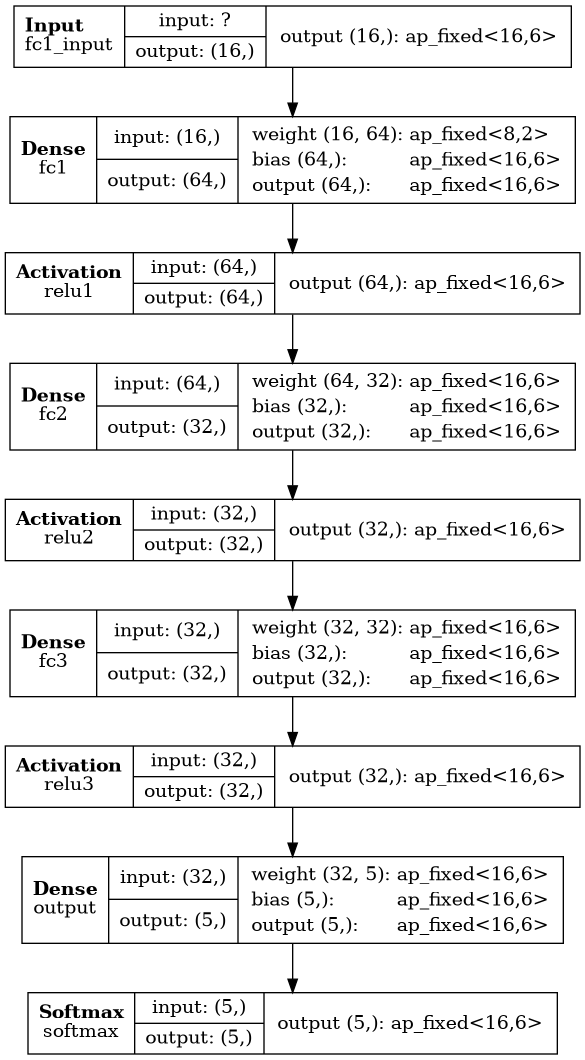

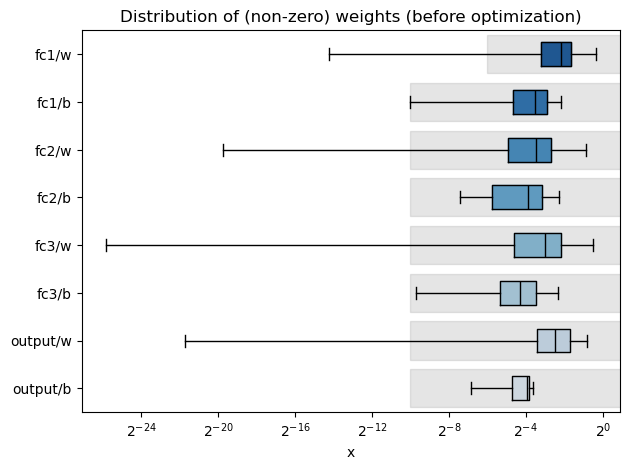

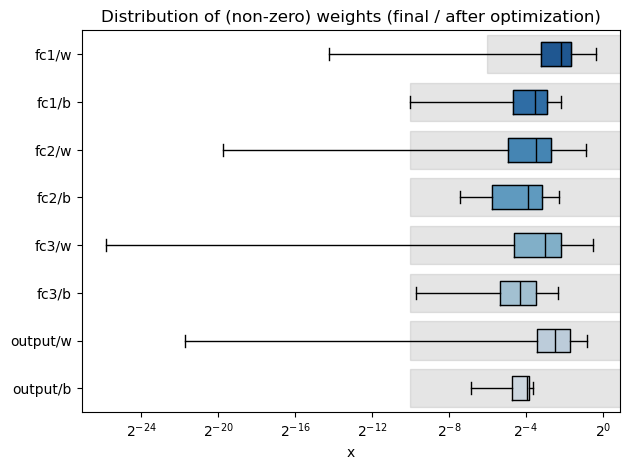

In [7]:
config['LayerName']['fc1']['Precision']['weight'] = 'ap_fixed<8,2>'
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj_2', part='xc7vx690tffg1761-2'
)
numerical(model=model, hls_model=hls_model)
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Trace
When we start using customised precision throughout the model, it can be useful to collect the output from each layer to find out when things have gone wrong. We enable this trace collection by setting `Trace = True` for each layer whose output we want to collect.

In [8]:
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vivado', output_dir='model_1/hls4ml_prj_2', part='xc7vx690tffg1761-2'
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
Creating HLS model


## Compile, trace, predict
Now we need to check that this model performance is still good after reducing the precision. We compile the `hls_model`, and now use the `hls_model.trace` method to collect the model output, and also the output for all the layers we enabled tracing for. This returns a dictionary with keys corresponding to the layer names of the model. Stored at that key is the array of values output by that layer, sampled from the provided data.
A helper function `get_ymodel_keras` will return the same dictionary for the Keras model.

We'll just run the `trace` for the first 1000 examples, since it takes a bit longer and uses more memory than just running `predict`. 

In [9]:
hls_model.compile()
hls4ml_pred, hls4ml_trace = hls_model.trace(X_test[:1000])
keras_trace = get_ymodel_keras(model, X_test[:1000])
y_hls = hls_model.predict(X_test)

Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
Processing fc1 in Keras model...
32/32 [==============================] - 0s 727us/step
Processing relu1 in Keras model...
32/32 [==============================] - 0s 3ms/step
Processing fc2 in Keras model...
32/32 [==============================] - 0s 6ms/step
Processing relu2 in Keras model...
32/32 [==============================] - 0s 8ms/step
Processing fc3 in Keras model...
32/32 [==============================] - 0s 2ms/step
Processing relu3 in Keras model...
32/32 [==============================] - 0s 2ms/step
Processing output in Keras model...
32/32 [==============================] - 0s 3ms/step
Processing softmax in Keras model...
32/32 [==============================] - 0s 1ms/step
Done taking outputs for Keras model.


## Inspect
Now we can print out, make plots, or do any other more detailed analysis on the output of each layer to make sure we haven't made the performance worse. And if we have, we can quickly find out where. Let's just print the output of the first layer, for the first sample, for both the Keras and hls4ml models.

In [10]:
print("Keras layer 'fc1', first sample:")
print(keras_trace['fc1'][0])
print("hls4ml layer 'fc1', first sample:")
print(hls4ml_trace['fc1'][0])

Keras layer 'fc1', first sample:
[-1.2488296   1.1395161   0.42435926  2.3110738  -1.3411198  -2.4829094
 -0.58294964 -0.27827787 -1.7337922   1.717336   -0.2269334   0.61306226
 -1.6866716  -1.2749201  -1.478241   -1.7118677   1.1545218   0.6437037
  1.3225788   0.40844542 -0.281246   -1.2950885  -1.3280356   1.6874503
 -0.6174492   2.4062462  -0.10747477  0.7611076  -1.1961901  -0.8091405
 -0.29817772  0.2754275  -0.25940824 -0.76234436  0.82103217  0.7633687
 -1.16173    -0.33868748 -1.0801053  -0.12439397  2.200518    0.51119167
 -0.4083456   1.1456019   0.16624431  2.3661342  -1.2727109  -2.050262
  0.1546902  -1.1954473   1.7656213   1.2200094   1.1441272   1.4120673
 -0.37001327  0.7089613   0.53374934  0.03977676  1.6794611  -2.1790698
  0.3041097  -0.14419371 -0.04164951 -1.4859861 ]
hls4ml layer 'fc1', first sample:
[-1.27832031  1.10742188  0.39355469  2.28320312 -1.38867188 -2.51660156
 -0.65332031 -0.28125    -1.76855469  1.703125   -0.27929688  0.60546875
 -1.68261719 -1.

## Compare
Let's see if we lost performance by using 8 bits for the weights of the first layer by inspecting the accuracy and ROC curve.

Keras  Accuracy: 0.7367831325301205
hls4ml Accuracy: 0.6949457831325301


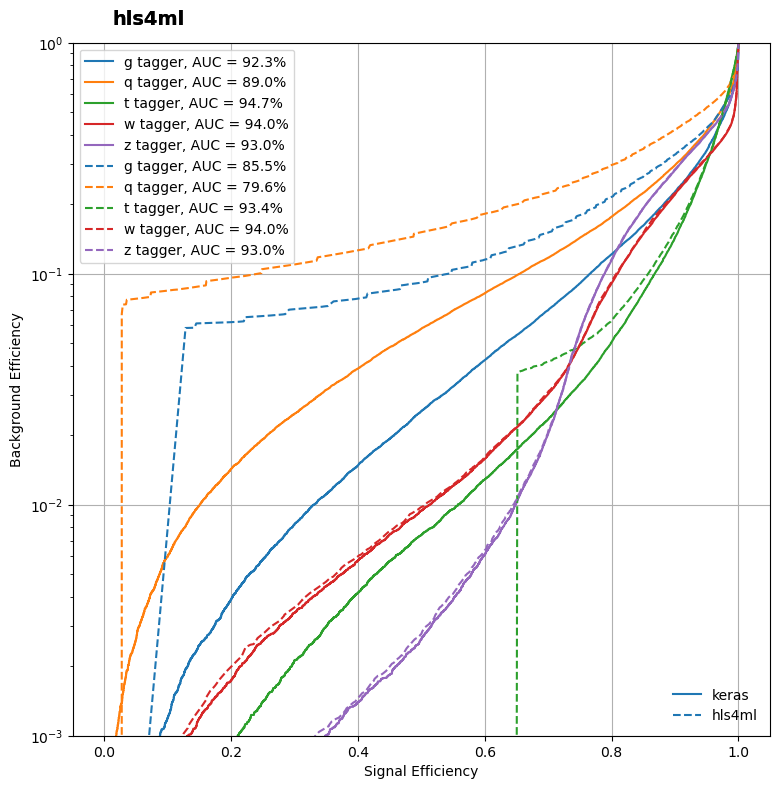

In [11]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Profiling & Trace Summary
We lost a small amount of accuracy compared to when we used `ap_fixed<16,6>`, but in many cases this difference will be small enough to be worth the resource saving. You can choose how aggressive to go with quantization, but it's always sensible to make the profiling plots even with the default configuration. Layer-level `trace` is very useful for finding when you reduced the bitwidth too far, or when the default configuration is no good for your model.

With this 'post training quantization', around 8-bits width generally seems to be the limit to how low you can go before suffering significant performance loss. In Part 4, we'll look at using 'training aware quantization' with QKeras to go much lower without losing much performance.

## ReuseFactor
Now let's look at the other configuration parameter: `ReuseFactor`.
Recall that `ReuseFactor` is our mechanism for tuning the parallelism:

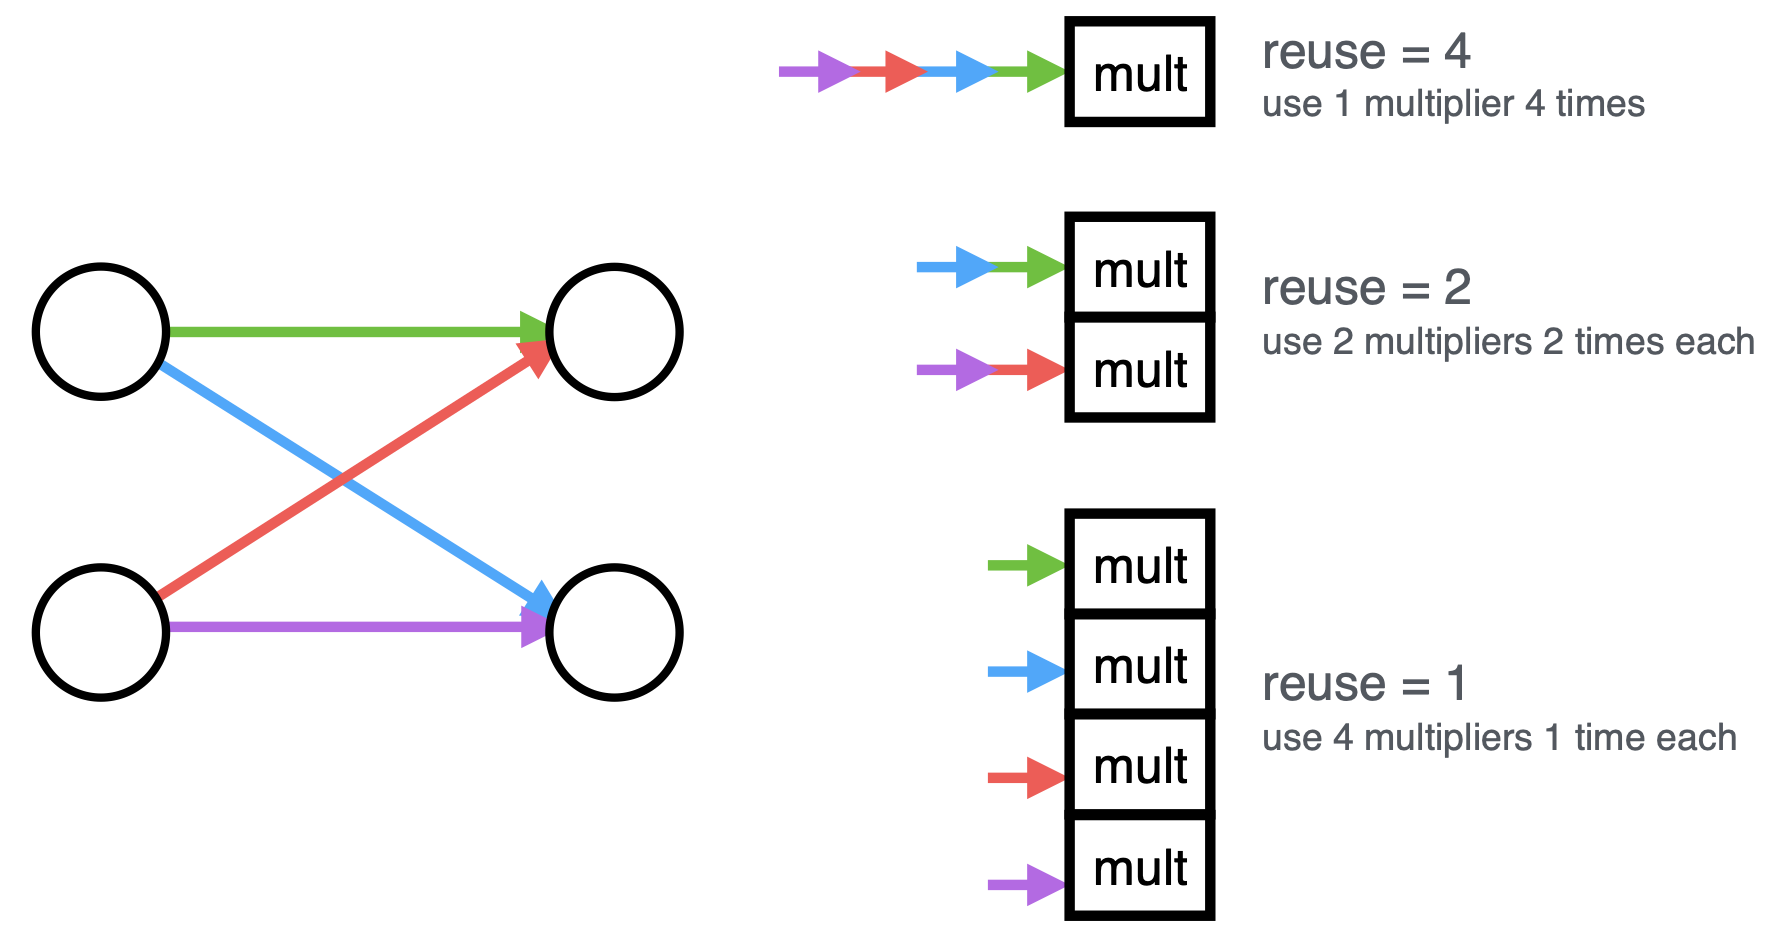

So now let's make a new configuration for this model, and set the `ReuseFactor` to `2` for every layer:
we'll compile the model, then evaulate its performance. (Note, by creating a new config with `granularity=Model`, we're implicitly resetting the precision to `ap_fixed<16,6>` throughout.) Changing the `ReuseFactor` should not change the classification results, but let's just verify that by inspecting the accuracy and ROC curve again!
Then we'll build the model.

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: Activation
Layer name: fc3, layer type: Dense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation
-----------------------------------
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
-----------------------------------
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[Non

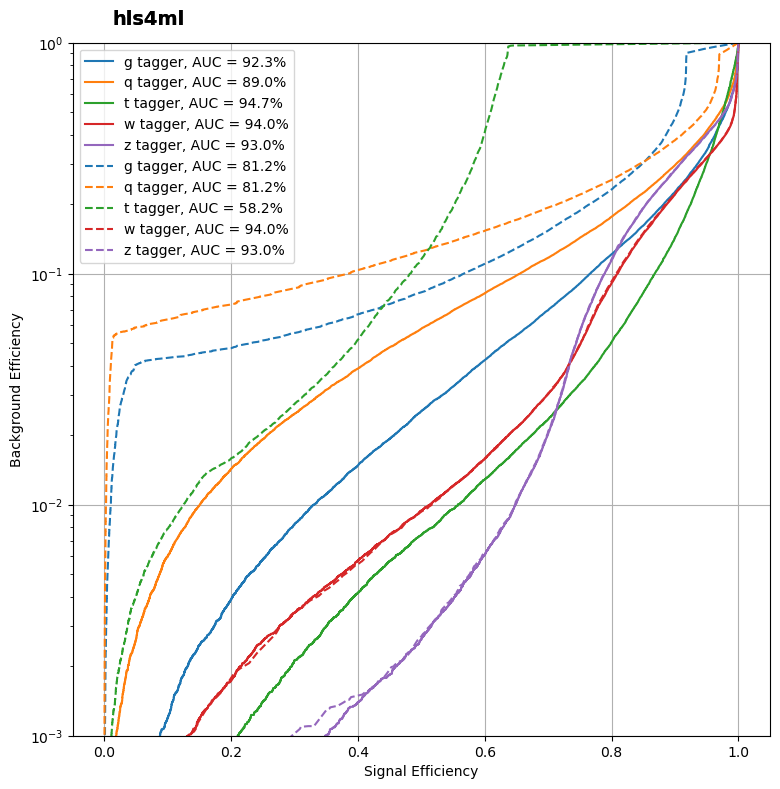

In [12]:
config = hls4ml.utils.config_from_keras_model(model, granularity='Model')
print("-----------------------------------")
print(config)
print("-----------------------------------")
# Set the ReuseFactor to 2 throughout
config['Model']['ReuseFactor'] = 2
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vivado', output_dir='model_1/hls4ml_prj_2', part='xc7vx690tffg1761-2'
)
hls_model.compile()
y_hls = hls_model.predict(X_test)
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle='--')

Now build the model

**This can take several minutes.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_1/hls4ml_prj_2/vivado_hls.log`

In [13]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'chanssen' on host 'hvm1' (Linux_x86_64 version 5.15.0-157-generic) on Tue Oct 14 22:07:14 PDT 2025
INFO: [HLS 200-10] On os Ubuntu 22.04.5 LTS
INFO: [HLS 200-10] In directory '/home/chanssen/HLS4ML_VS_MANUAL/documents/hls4ml-tutorial-modified/model_1/hls4ml_prj_2'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/chanssen/HLS4ML_VS_MANUAL/documents/hls4ml-tutorial-modified/model_1/hls4ml_prj_2/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test

{'EstimatedClockPeriod': '4.890',
 'BestLatency': '24',
 'WorstLatency': '24',
 'IntervalMin': '2',
 'IntervalMax': '2',
 'BRAM_18K': '4',
 'DSP48E': '2115',
 'FF': '76019',
 'LUT': '143920',
 'URAM': '0',
 'AvailableBRAM_18K': '2940',
 'AvailableDSP48E': '3600',
 'AvailableFF': '866400',
 'AvailableLUT': '433200',
 'AvailableURAM': '0'}

And now print the report, compare this to the report from Exercise 1

In [14]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj_2')

Found 1 solution(s) in model_1/hls4ml_prj_2/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Tue Oct 14 22:20:58 2025

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: virtex7
* Target device:  xc7vx690t-ffg1761-2


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.890|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   24|   24|    2|    2| function |
    +-----+-----+-----+-----+-------

In [15]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')

Found 1 solution(s) in model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Thu Oct  9 23:38:28 2025

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: virtex7
* Target device:  xc7vx690t-ffg1761-2


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.890|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   27|   27|    1|    1| function |
    +-----+-----+-----+-----+---------

## Exercise
- Recall the outcome of the exercise of part 1 where we estimated how many DSPs our network should use.
How does this change now we've used `ReuseFactor = 2` for the network? Does the expectation match the report this time?